# Natural Gas Prediction Model

## Purpose: 
To predict gas prices using both a Linear Regression Model and a Sinusoidal Regression for contract evaluations.  Then compare which gives a more accurate analysis on Natural Gas Prices dataset from the Henry Hub Distribution Hub. 


## Bottom-Line Up Front

Sinusoidal Model assumes smooth symmetric pattern, the plot does not follow a perfect wave, the one hot encoding allows each month to have its own coefficient.

The model when accounting for economic indicators (S&P 500) and weather (Temp) it has an RMSE of 1.01 but with Oil Prices has an RMSE of 1.22. 

The reason I suspect is that based off historical data Oil and gas prices moved together, but during the test period Oil and Gas moved in opposite directions adding noise and skewing the model. 


In [ ]:
# Install libraries
!python -m pip install --upgrade pip -q
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl -q
!pip install notebook -q
!pip install nbconvert -q
!pip install tabulate -q
!pip install xlrd -q
!pip install yfinance -q

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
from sklearn.preprocessing import StandardScaler 

warnings.filterwarnings('ignore')

# Load the data

In [2]:
# Natural Gas Price Data
df = pd.read_excel('RNGWHHDm.xls', sheet_name='Data 1', skiprows=2)
display(df.tail())
display(df.info())

,Date,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
343,2025-08-15,2.91
344,2025-09-15,2.97
345,2025-10-15,3.19
346,2025-11-15,3.79
347,2025-12-15,4.26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Date                                                        348 non-null    datetime64[ns]
 1   Henry Hub Natural Gas Spot Price (Dollars per Million Btu)  348 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 KB


None

In [3]:
# convert 'Dates' column to datetime and 'Prices' column to numeric
df.rename(columns={'Date': 'Dates', 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'Prices'}, inplace=True)
df['Dates'] = pd.to_datetime(df['Dates'])
df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')
display(df.head())
display(df.tail())
display(df.info())


,Dates,Prices
0,1997-01-15,3.45
1,1997-02-15,2.15
2,1997-03-15,1.89
3,1997-04-15,2.03
4,1997-05-15,2.25


,Dates,Prices
343,2025-08-15,2.91
344,2025-09-15,2.97
345,2025-10-15,3.19
346,2025-11-15,3.79
347,2025-12-15,4.26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   348 non-null    datetime64[ns]
 1   Prices  348 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 KB


None

In [4]:
# import s&p 500 data from yfinance ticker ^GSPC with interval 1mo to fetch monthly data 
# fetch from 1997-2005 to match my natural gas data
sp500_data = yf.download('^GSPC', start='1997-01-01', end='2025-12-31', interval='1mo')['Close']
sp500_data.reset_index(inplace=True)
display(sp500_data.tail())
display(sp500_data.info())

[*********************100%***********************]  1 of 1 completed


Ticker,Date,^GSPC
343,2025-08-01,6460.259766
344,2025-09-01,6688.459961
345,2025-10-01,6840.200195
346,2025-11-01,6849.089844
347,2025-12-01,6845.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    348 non-null    datetime64[ns]
 1   ^GSPC   348 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 KB


None

In [5]:
# Rename columns and convert 'Dates' to datetime and 'SP500_Close' to numeric
sp500_data = sp500_data.rename(columns={'Date': 'Dates', '^GSPC': 'SP500_Close'})
sp500_data['Dates'] = pd.to_datetime(sp500_data['Dates'], format='%Y%m', errors='coerce')  # Parse 'Dates' with the specified format
sp500_data['SP500_Close'] = pd.to_numeric(sp500_data['SP500_Close'], errors='coerce')
display(sp500_data.head())
display(sp500_data.info())

Ticker,Dates,SP500_Close
0,1997-01-01,786.159973
1,1997-02-01,790.820007
2,1997-03-01,757.119995
3,1997-04-01,801.340027
4,1997-05-01,848.280029


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Dates        348 non-null    datetime64[ns]
 1   SP500_Close  348 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 KB


None

In [6]:
# Import Temperature data
df_Temp = pd.read_csv('data.csv', skiprows=2)
display(df_Temp.head())
display(df_Temp.info())

,Date,Value
0,199701,29.97
1,199702,36.05
2,199703,44.65
3,199704,47.91
4,199705,59.38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    348 non-null    int64  
 1   Value   348 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.6 KB


None

In [7]:
# Rename columns and convert 'Dates' to datetime and 'Avg_US_Temp' to numeric
df_Temp.rename(columns={'Date': 'Dates', 'Value':'Avg_US_Temp'}, inplace=True)
df_Temp['Dates'] = df_Temp['Dates'].astype(str)  # Ensure 'Dates' is a string before parsing
df_Temp['Dates'] = pd.to_datetime(df_Temp['Dates'], format='%Y%m', errors='coerce')  # Parse 'Dates' with the specified format
df_Temp['Avg_US_Temp'] = pd.to_numeric(df_Temp['Avg_US_Temp'], errors='coerce')
display(df_Temp.head())
display(df_Temp.info())

,Dates,Avg_US_Temp
0,1997-01-01,29.97
1,1997-02-01,36.05
2,1997-03-01,44.65
3,1997-04-01,47.91
4,1997-05-01,59.38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Dates        348 non-null    datetime64[ns]
 1   Avg_US_Temp  348 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 KB


None

In [8]:
# Load Oil Price Data
df_oil = pd.read_excel('F000000__3m.xls', sheet_name='Data 1', skiprows=2)
df_oil['Date'] = pd.to_datetime(df_oil['Date'])
df_oil = df_oil[df_oil['Date'] >= '1997-01-01']
df_oil = df_oil.sort_values('Date').reset_index(drop=True)
display(df_oil.head())

,Date,U.S. Crude Oil First Purchase Price (Dollars per Barrel)
0,1997-01-15,21.76
1,1997-02-15,19.38
2,1997-03-15,17.83
3,1997-04-15,16.63
4,1997-05-15,17.23


In [9]:
df_oil.rename(columns={'Date': 'Dates', 'U.S. Crude Oil First Purchase Price (Dollars per Barrel)': 'Oil_Price'}, inplace=True) # Ensure 'Dates' is a string before parsing
df_oil['Oil_Price'] = pd.to_numeric(df_oil['Oil_Price'], errors='coerce')
display(df_oil.head())

,Dates,Oil_Price
0,1997-01-15,21.76
1,1997-02-15,19.38
2,1997-03-15,17.83
3,1997-04-15,16.63
4,1997-05-15,17.23


In [10]:
display(df_oil.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Dates      347 non-null    datetime64[ns]
 1   Oil_Price  347 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 KB


None

In [11]:
# Updata the dataframe to include weather data

df['Merge_Date'] = df['Dates'].dt.to_period('M')
df_Temp['Merge_Date'] = df_Temp['Dates'].dt.to_period('M')

df = pd.merge(df, df_Temp[['Merge_Date', 'Avg_US_Temp']], on='Merge_Date', how='left')
df.drop(columns=['Merge_Date'], inplace=True)
display(df.head())
display(df.info())

,Dates,Prices,Avg_US_Temp
0,1997-01-15,3.45,29.97
1,1997-02-15,2.15,36.05
2,1997-03-15,1.89,44.65
3,1997-04-15,2.03,47.91
4,1997-05-15,2.25,59.38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Dates        348 non-null    datetime64[ns]
 1   Prices       348 non-null    float64       
 2   Avg_US_Temp  348 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.3 KB


None

In [12]:
# Update the dataframe to include s&p 500 data

df['Merge_Date'] = df['Dates'].dt.to_period('M')
sp500_data['Merge_Date'] = sp500_data['Dates'].dt.to_period('M')

df = pd.merge(df, sp500_data[['Merge_Date', 'SP500_Close']], on='Merge_Date', how='left')
df.drop(columns=['Merge_Date'], inplace=True)
display(df.head())
display(df.info())

,Dates,Prices,Avg_US_Temp,SP500_Close
0,1997-01-15,3.45,29.97,786.159973
1,1997-02-15,2.15,36.05,790.820007
2,1997-03-15,1.89,44.65,757.119995
3,1997-04-15,2.03,47.91,801.340027
4,1997-05-15,2.25,59.38,848.280029


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Dates        348 non-null    datetime64[ns]
 1   Prices       348 non-null    float64       
 2   Avg_US_Temp  348 non-null    float64       
 3   SP500_Close  348 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.0 KB


None

In [13]:
# Update the dataframe to include oil price data

df['Merge_Date'] = df['Dates'].dt.to_period('M')
df_oil['Merge_Date'] = df_oil['Dates'].dt.to_period('M')

df = pd.merge(df, df_oil[['Merge_Date', 'Oil_Price']], on='Merge_Date', how='left')
df.drop(columns=['Merge_Date'], inplace=True)   
display(df.head())
display(df.tail())

,Dates,Prices,Avg_US_Temp,SP500_Close,Oil_Price
0,1997-01-15,3.45,29.97,786.159973,21.76
1,1997-02-15,2.15,36.05,790.820007,19.38
2,1997-03-15,1.89,44.65,757.119995,17.83
3,1997-04-15,2.03,47.91,801.340027,16.63
4,1997-05-15,2.25,59.38,848.280029,17.23


,Dates,Prices,Avg_US_Temp,SP500_Close,Oil_Price
343,2025-08-15,2.91,73.38,6460.259766,63.37
344,2025-09-15,2.97,67.95,6688.459961,62.23
345,2025-10-15,3.19,56.97,6840.200195,58.89
346,2025-11-15,3.79,46.74,6849.089844,58.13
347,2025-12-15,4.26,37.80,6845.500000,NaN


In [14]:
print([col for col in df.columns if 'Oil' in col])

['Oil_Price']


In [15]:
print(df[['Dates', 'Prices', 'Oil_Price']].tail(5))

         Dates  Prices  Oil_Price
343 2025-08-15    2.91      63.37
344 2025-09-15    2.97      62.23
345 2025-10-15    3.19      58.89
346 2025-11-15    3.79      58.13
347 2025-12-15    4.26        NaN


In [16]:
df['Oil_Price'] = df['Oil_Price'].fillna(55.26)
display(df.tail())

,Dates,Prices,Avg_US_Temp,SP500_Close,Oil_Price
343,2025-08-15,2.91,73.38,6460.259766,63.37
344,2025-09-15,2.97,67.95,6688.459961,62.23
345,2025-10-15,3.19,56.97,6840.200195,58.89
346,2025-11-15,3.79,46.74,6849.089844,58.13
347,2025-12-15,4.26,37.80,6845.500000,55.26


# RELATIONSHIP BETWEEN S&P 500 TO GAS PRICES

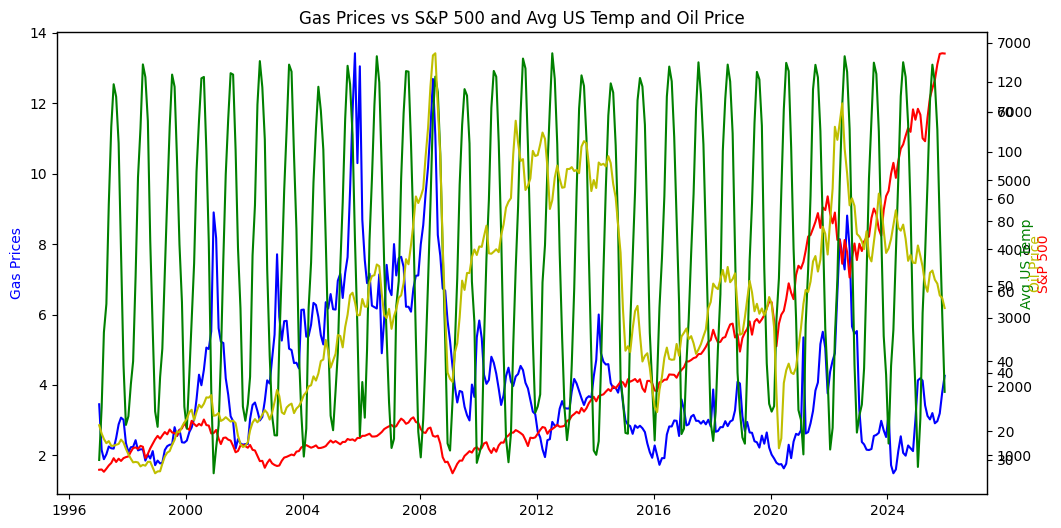

In [27]:
# Plot Gas Prices vs S&P 500

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df['Dates'], df['Prices'], 'b-', label='Gas Prices')
ax1.set_ylabel('Gas Prices', color='b')

ax2 = ax1.twinx()
ax2.plot(df['Dates'], df['SP500_Close'], 'r-', label='S&P 500')
ax2.set_ylabel('S&P 500', color='r')

ax3 = ax1.twinx()
ax3.plot(df['Dates'], df['Avg_US_Temp'], 'g-', label='Avg US Temp')
ax3.set_ylabel('Avg US Temp', color='g')

ax4 = ax1.twinx()
ax4.plot(df['Dates'], df['Oil_Price'], 'y-', label='Oil Price')
ax4.set_ylabel('Oil Price', color='y')

plt.title('Gas Prices vs S&P 500 and Avg US Temp and Oil Price')
plt.show()

In [18]:
# Clean up data and create time-based index and one-hot encoding the month
df['time_index'] = range(len(df))
df['Month'] = df['Dates'].dt.month
df = pd.get_dummies(df, columns=['Month']) # after encoding month, convert to 1 or 0 instead of true or false

In [19]:
print(df.head())
print(df.info())

       Dates  Prices  Avg_US_Temp  SP500_Close  Oil_Price  time_index  \
0 1997-01-15    3.45        29.97   786.159973      21.76           0   
1 1997-02-15    2.15        36.05   790.820007      19.38           1   
2 1997-03-15    1.89        44.65   757.119995      17.83           2   
3 1997-04-15    2.03        47.91   801.340027      16.63           3   
4 1997-05-15    2.25        59.38   848.280029      17.23           4   

   Month_1  Month_2  Month_3  Month_4  Month_5  Month_6  Month_7  Month_8  \
0     True    False    False    False    False    False    False    False   
1    False     True    False    False    False    False    False    False   
2    False    False     True    False    False    False    False    False   
3    False    False    False     True    False    False    False    False   
4    False    False    False    False     True    False    False    False   

   Month_9  Month_10  Month_11  Month_12  
0    False     False     False     False  
1    False  

## Sinusoidal Regression Model 

## Methodology
### Sinusoidal Regression Model
- Convert everything into a numpy array
- Calculate trend line
- the y intercept
- calculate the sine and cosine coefficient
- Calculate the Amplitude and Phase shift
- Create a function that uses the sinusoidal Regression model to predict prices


In [20]:
# Convert Dates to datetime format in numpy array
prices = np.array(df['Prices'])
temperature = np.array(df['Avg_US_Temp'])
dates = np.array(df['Dates'])
sp_500_prices = np.array(df['SP500_Close'])
oil_prices = np.array(df['Oil_Price'])
dates = pd.to_datetime(dates)

In [22]:
# Calculate trend line using Linear Regression to handle multiple variables

# Create Feature needed 
# convert dates to numerical format (days since epoch)

df['day_since_epoch'] = pd.to_datetime(df['Dates']).astype(np.int64) // 10**9 // 86400  # Convert to days since epoch

# Calculate sine(2π * days / 12) and cosine(2π * days / 12) components for seasonality
df['sine'] = np.sin(2 * np.pi * df['day_since_epoch']/ 365.25)
df['cosine'] = np.cos(2*np.pi * df['day_since_epoch']/ 365.25)

# Split the data into features and target variable
X = df[['day_since_epoch', 'SP500_Close', 'Avg_US_Temp', 'Oil_Price', 'sine', 'cosine']]
y = df['Prices']


# Split the data into train_test_split
X_train = X[:324] # train on first 324 samples or 27 years of data
X_test = X[324:] # test on last 12 years of data
y_train = y[:324] # train on first 324 samples or 27 years of data
y_test = y[324:] # test on last 12 years of data

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# predict and calculate RMSE
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Print m1, m2, and b
m1_time = model.coef_[0]
m2_sp_500 = model.coef_[1]
m3_Avg_US_Temp = model.coef_[2]
m4_Oil_Price = model.coef_[3]
u = model.coef_[4]
w = model.coef_[5]
b = model.intercept_

print(f"Coefficient for Time_Index (m1): {m1_time:.2f}")
print(f"Coefficient for SP500_Close (m2): {m2_sp_500:.2f}")
print(f"Coefficient for Avg_US_Temp (m3): {m3_Avg_US_Temp:.2f}")
print(f"Coefficient for Oil_Price (m4): {m4_Oil_Price:.2f}")
print(f"Coefficient for sine component (u): {u:.2f}")
print(f"Coefficient for cosine component (w): {w:.2f}")
print(f"Intercept (b): {b:.2f}")

formula = f"Price = {m1_time:.2f} * Time_Index + {m2_sp_500:.2f} * SP500_Close  + {m3_Avg_US_Temp:.2f}* Temp + {m4_Oil_Price:.2f}*Oil_Price + {u:.2f}(sine) + {w:.2f}(cosine) + {b:.2f}intercept"
print("Linear Regression Formula:")
print(formula)  


Root Mean Squared Error (RMSE): 1.22
Coefficient for Time_Index (m1): -1.39
Coefficient for SP500_Close (m2): 0.38
Coefficient for Avg_US_Temp (m3): -1.77
Coefficient for Oil_Price (m4): 1.38
Coefficient for sine component (u): -0.55
Coefficient for cosine component (w): -1.55
Intercept (b): 4.19
Linear Regression Formula:
Price = -1.39 * Time_Index + 0.38 * SP500_Close  + -1.77* Temp + 1.38*Oil_Price + -0.55(sine) + -1.55(cosine) + 4.19intercept


In [24]:
# Drop Oil_Price and re-run the model to see how much it impacts the model performance

df_no_oil = df.drop(columns=['Oil_Price'])
display(df_no_oil.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Dates            348 non-null    datetime64[ns]
 1   Prices           348 non-null    float64       
 2   Avg_US_Temp      348 non-null    float64       
 3   SP500_Close      348 non-null    float64       
 4   time_index       348 non-null    int64         
 5   Month_1          348 non-null    bool          
 6   Month_2          348 non-null    bool          
 7   Month_3          348 non-null    bool          
 8   Month_4          348 non-null    bool          
 9   Month_5          348 non-null    bool          
 10  Month_6          348 non-null    bool          
 11  Month_7          348 non-null    bool          
 12  Month_8          348 non-null    bool          
 13  Month_9          348 non-null    bool          
 14  Month_10         348 non-null    bool     

None

In [26]:
# Calculate trend line using Linear Regression to handle multiple variables

# Create Feature needed 
# convert dates to numerical format (days since epoch)

df_no_oil['day_since_epoch'] = pd.to_datetime(df_no_oil['Dates']).astype(np.int64) // 10**9 // 86400  # Convert to days since epoch

# Calculate sine(2π * days / 12) and cosine(2π * days / 12) components for seasonality
df_no_oil['sine'] = np.sin(2 * np.pi * df_no_oil['day_since_epoch']/ 365.25)
df_no_oil['cosine'] = np.cos(2*np.pi * df_no_oil['day_since_epoch']/ 365.25)

# Split the data into features and target variable
X = df_no_oil[['day_since_epoch', 'SP500_Close', 'Avg_US_Temp', 'sine', 'cosine']]
y = df_no_oil['Prices']


# Split the data into train_test_split
X_train = X[:324] # train on first 324 samples or 27 years of data
X_test = X[324:] # test on last 12 years of data
y_train = y[:324] # train on first 324 samples or 27 years of data
y_test = y[324:] # test on last 12 years of data

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# predict and calculate RMSE
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE) No Oil: {rmse:.2f}')

# Print m1, m2, and b
m1_time = model.coef_[0]
m2_sp_500 = model.coef_[1]
m3_Avg_US_Temp = model.coef_[2]
u = model.coef_[3]
w = model.coef_[4]
b = model.intercept_

print(f"Coefficient for Time_Index (m1): {m1_time:.2f}")
print(f"Coefficient for SP500_Close (m2): {m2_sp_500:.2f}")
print(f"Coefficient for Avg_US_Temp (m3): {m3_Avg_US_Temp:.2f}")
print(f"Coefficient for sine component (u): {u:.2f}")
print(f"Coefficient for cosine component (w): {w:.2f}")
print(f"Intercept (b): {b:.2f}")

formula = f"Price = {m1_time:.2f} * Time_Index + {m2_sp_500:.2f} * SP500_Close  + {m3_Avg_US_Temp:.2f}* Temp + {u:.2f}(sine) + {w:.2f}(cosine) + {b:.2f}intercept"
print("Linear Regression Formula:")
print(formula)  


Root Mean Squared Error (RMSE) No Oil: 1.01
Coefficient for Time_Index (m1): 0.09
Coefficient for SP500_Close (m2): -0.44
Coefficient for Avg_US_Temp (m3): -2.37
Coefficient for sine component (u): -0.74
Coefficient for cosine component (w): -2.20
Intercept (b): 4.19
Linear Regression Formula:
Price = 0.09 * Time_Index + -0.44 * SP500_Close  + -2.37* Temp + -0.74(sine) + -2.20(cosine) + 4.19intercept


In [ ]:
print(df[['SP500_Close', 'Oil_Price', 'Prices']].corr())

In [ ]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

In [ ]:
# Function to predict future prices

def predict_price_sinusoidal(user_input, sp500_value):
    if sp500_value is None:
        sp500_value = df['SP500_Close'].iloc[-1]
        sp500_value = scaler.transform(sp500_value)# Use the last known S&P 500 value if not provided
    # Convert user input date to ordinal
    date = pd.to_datetime(user_input).value //10**9 // 86400
    x = date
    sine_value = np.sin(2 * np.pi * x / 365.25)
    cosine_value = np.cos(2 * np.pi * x / 365.25)
    price = (m1_time * x) + (m2_sp_500 * sp500_value) + (u * sine_value) + (w * cosine_value) + b
    
    return Price
    

In [ ]:
# TEST THE FUNCTION
test_date = '2025-01-30'
sp500_value = 
predict_price_sinusoidal(test_date, sp500_value)

In [ ]:
print(len(df))

## Model Comparisons: 

Compare the models to the actual data, and visualize how it compares. 

In [ ]:
# To check how the model compares to the actual data. 

predicted_all_sinusoidal = trend_line + ((u * sine_time)) + (w * cosine_time)
predicted_all_linear = np.array([predict_price_linear(date) for date in df['Dates']])

plt.figure(figsize=(12,6))
plt.plot(dates, y, label ='Actual Prices', color ='Black')
plt.plot(dates, predicted_all_linear, label ='Predicted Prices Linear', color ='red', linestyle='--')
plt.plot(dates, predicted_all_sinusoidal, label ='Predicted Prices Sinusoidal', color ='blue', linestyle='--')
plt.xlabel('Dates')
plt.ylabel('Natural Gas Prices')
plt.title('Actual vs Predicted Natural Gas Prices') 
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Check with one is better
error_sinusoidal = y - predicted_all_sinusoidal # get residual amount compared to actual prices
error_linear = y - predicted_all_linear

squared_errors_sinusoidal = error_sinusoidal ** 2 # square the errors
squared_errors_linear = error_linear ** 2   

mean_squared_error_sinusoidal = np.mean(squared_errors_sinusoidal) # find the mean of the squared errors
mean_squared_error_linear = np.mean(squared_errors_linear)  

rmse_sinusoidal = np.sqrt(mean_squared_error_sinusoidal) # find the root mean squared error which gives a dollar amount
rmse_linear = np.sqrt(mean_squared_error_linear)

print(f'RMSE Sinusoidal Model: {rmse_sinusoidal:.3f}')
print(f'RMSE Linear Model: {rmse_linear:.3f}')
if rmse_sinusoidal < rmse_linear:
    print(f'Sinusoidal Model performs better than Linear Model by {rmse_linear - rmse_sinusoidal:.3f} in RMSE')
else:
    print(f'Linear Model performs better than Sinusoidal Model by {rmse_sinusoidal - rmse_linear:.3f} in RMSE')

# Function To Calculate Contract Value

This is a function that returns the value of a contract based on:
- The injection date (YYYY-MM-DD)
- The withdrawal date (YYYY-MM-DD)
- The maximum the storage facility can hold (in millions of MMBtu)
- The volume purchased (in millions of MMBtu)
- The storage fee (in thousands, e.g., 100 = $100,000/month)
- The injection fee (in thousands per million MMBtu)
- The withdrawal fee (in thousands per million MMBtu)
- The transport rate each way (in thousands, e.g., 50 = $50,000)

## Example

# Buy 1 million MMBtu in June, sell in December
value = price_contract('2025-06-01', '2025-12-01', 5, 1, 100, 10, 10, 50)
print(f"Contract Value: ${value:,.2f}")
# Output: Contract Value: $690,000.00


In [ ]:
def price_contract(injection_date, withdrawal_date, max_volume_storage_capacity, volume, storage_rate, injection_rate, withdrawal_rate, transport_rate):
    # Step 1: Calculate the Buying Price at Injection Date
    injection_date = datetime.datetime.strptime(str(injection_date), '%Y-%m-%d')
    withdrawal_date = datetime.datetime.strptime(str(withdrawal_date), '%Y-%m-%d')
    buying_price = predict_price_sinusoidal(injection_date)

    if max_volume_storage_capacity < volume:
        print(f"Volume exceeds maximum storage capacity. {max_volume_storage_capacity} capacity will be used.")
        volume = max_volume_storage_capacity
    actual_volume = volume * 1e6 
    # Step 2: Calculate the Selling Price at Withdrawal Date
    selling_price = predict_price_sinusoidal(withdrawal_date)
    
    # Step 3: Calculate Total Storage Cost
    storage_cost = (((withdrawal_date - injection_date).days / 30)* (storage_rate * 1000))
    
    # Step 5: Calculate Total Transport Cost
    Total_Transport_cost  = (transport_rate*1000) * 2
    
    # Step 6: Calculate injection cost
    injection_cost = (injection_rate*1000) * volume
    
    # Step 7: Calculate withdrawal cost
    withdrawal_cost = (withdrawal_rate*1000) * volume
    
    # Step 8: Calculate Value
    Value = (selling_price * actual_volume) - (buying_price * actual_volume) - storage_cost - injection_cost - withdrawal_cost - Total_Transport_cost
    return Value

In [ ]:
# Test 1: Under max
value = price_contract('2025-06-01', '2025-12-01', 5, 1, 100, 10, 10, 50)
print(f"Contract Value: ${value:,.2f}")

# Test 2: Over max (should warn and cap at 5)
value = price_contract('2025-06-01', '2025-12-01', 5, 10, 100, 10, 10, 50)
print(f"Contract Value: ${value:,.2f}")

# Test 3: Exactly 5 (no cap needed)
value = price_contract('2025-06-01', '2025-12-01', 5, 5, 100, 10, 10, 50)
print(f"Contract Value: ${value:,.2f}")

In [ ]:
while True:
    injection_date = input("Enter the injection date (YYYY-MM-DD)  (or 'q' to quit): ")
    if injection_date.lower() == 'q':
        break
    
    withdrawal_date = input("Enter the withdrawal date (YYYY-MM-DD)  (or 'q' to quit): ")
    if withdrawal_date.lower() == 'q':
        break
    max_volume_storage_capacity = (input("Enter the maximum volume storage capacity in million MMBtu (ex 10 for 10,000,000) or 'q' to quit: "))
    if max_volume_storage_capacity.lower() == 'q':
        break
    max_volume_storage_capacity = float(max_volume_storage_capacity)
    volume = (input("Enter the volume in million MMBtu (ex 1,2 for 1,000,000) or 'q' to quit: "))
    if volume.lower() == 'q':
        break
    volume = float(volume)
    storage_rate = (input("Enter the storage rate (for ex 100 for $100,000) or 'q' to quit: "))
    if storage_rate.lower() == 'q':
        break
    storage_rate = float(storage_rate)
    injection_rate = (input("Enter the injection rate (for ex 10 for $10,000 or 'q' to quit: "))
    if injection_rate.lower() == 'q':
        break
    injection_rate = float(injection_rate)
    withdrawal_rate = (input("Enter the withdrawal rate (for ex 10 for $10,000 or 'q' to quit: "))
    if withdrawal_rate.lower() == 'q':
        break
    withdrawal_rate = float(withdrawal_rate)
    transport_rate = (input("Enter the transport rate (for ex 5 for $5,000 or 'q' to quit: "))
    if transport_rate.lower() == 'q':
        break
    transport_rate = float(transport_rate)
    
    try:
        print(f"Contract Value: ${price_contract(injection_date, withdrawal_date, max_volume_storage_capacity, volume, storage_rate, injection_rate, withdrawal_rate, transport_rate):.2f}")
    except Exception as e:
        print(f"Error: {e}. Please enter a valid entry.")

## Future Improvement to Tests: 

- Try daily time index instead of monthly to see if i can improve accuracy. 